# Tutorial #2: Creating Network Finite State Machines from a Boolean Gene Regulatory Network Model 
Here we demonstrate how to create Network Finite State Machines (NFSMs) from a Boolean, logic-based Gene Regulatory Network (GRN) model. Here we use the [MAPK Cancer Cell Fate Network](https://research.cellcollective.org/dashboard#module/7984:1/mapk-cancer-cell-fate-network/1) created by [Grieco et. al - 2017](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003286), sourced from the Cell Collective database. In the Boolean model, the expression state (as True = 1 or False = 0) of each node was prescribed by logic equations, which represent the activation or inhibition interactions of the expression of one node upon the expression of another. 

Here we specifically run-through the following steps to arrive at NFSMs:
1. We show how to load the GRN from the Cellnition network library, where the [MAPK_net](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/network_library.py#L2277) is loaded from the Cellnition network library into a [BooleanNet](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/boolean_networks.py#L25) class and the network is built using the [build_network_from_edges method](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/network_abc.py#L89) of the BooleanNet. We characterize the network, determining cycles, node input and output degree, node hierarchical level (see [Moutsinas et. al - 2021](https://www.nature.com/articles/s41598-021-93161-4)), etc, using the [characterize_graph](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/network_abc.py#L214) method of BooleanNet), and generate visualizations for the GRN as a network diagram using [plot_network](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/networks_toolbox/netplot.py#L8). We note that other networks can be loaded from the Cellnition [network library](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/network_library.py#L1) that readily work with the BooleanNet solver. We also note that nodes of the network have been automatically categorized as inputs, outputs, and internal nodes when the 'characterize_graph' method is utilized. 
2. We show how to use the loaded GRN to automatically construct an analytical Boolean model consisting of logical expressions describing node expressions using the [build_boolean_model](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/boolean_networks.py#L111) method of BooleanNet. We show how to visualize and export these equations for use in publications and reports using the [save_model_equations](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/boolean_networks.py#L754) method of BooleanNet.
3. We next instantiate the [BoolStateMachine](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/networks_toolbox/boolean_state_machine.py#L26) class, and use the Boolean model of the GRN with the BoolStateMachine object to search for equilibrium states of the GRN system for each member of the set of possible input states using the [steady_state_solutions_search](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/networks_toolbox/boolean_state_machine.py#L166) method of BoolStateMachine. These equilibrium states are automatically subjected to a characterization to determine their dynamic quality (e.g. as a point attractor, metastable saddle, or continuously oscilating limit cycle, etc, see the code in the [net_state_compute](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/boolean_networks.py#L342) method of BooleanNet for details). Finally, we show how to write export a visualization of the matrix of unique equilibrium states using the [plot_sols_array](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/network_models/network_abc.py#L652) method of BooleanNet.
4. We show how to run the state-machine construction routine, [create_transition_network](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/networks_toolbox/boolean_state_machine.py#L258) of BoolStateMachine, to build both of the NFSM types for the Boolean GRN model.
5. We next show how to save the NFSM graphs, and to use the [plot_state_transition_network](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/networks_toolbox/boolean_state_machine.py#L490) method of BoolStateMachine to plot the 'general' NFSM (G-NFSM) and the [plot_state_perturbation_network](https://github.com/betsee/cellnition/blob/46601f3294d9f14cc87d25aa12ed09215fec6114/cellnition/science/networks_toolbox/boolean_state_machine.py#L490) method of BoolStateMachine to plot the event-driven NFSM (E-NFSM).   

In [2]:
import os
import csv
import copy
import itertools
from collections import OrderedDict
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors
from matplotlib import colormaps
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Circle
import pandas as pd
from scipy.cluster.hierarchy import fclusterdata
import networkx as nx

from cellnition.science.network_models.basic_network import BasicNet
from cellnition.science.network_models.network_enums import (EdgeType, 
                                                             GraphType, 
                                                             NodeType, 
                                                             InterFuncType, 
                                                             CouplingType, 
                                                             EquilibriumType
                                                            )
# from cellnition.science.network_workflow import NetworkWorkflow
from cellnition.science.networks_toolbox.netplot import plot_network

from cellnition.science.network_models.network_library import (StemCellNet, 
                                                               StemCellTriad, 
                                                               hESC_9a, 
                                                               TrinodeCycle,
                                                               TrinodeCycleFullyConnected,
                                                               TrinodeCycleFullyConnected2,
                                                               StemCellTriadChain,
                                                              AKTNet,
                                                              BinodeCycle,
                                                              MAPK_net)

from cellnition.science.network_models.boolean_networks import BooleanNet
from cellnition.science.networks_toolbox.boolean_state_machine import BoolStateMachine
from cellnition.science.networks_toolbox.state_machine import StateMachine

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mono_edge = True
fimg = '.png'

In [4]:
# Save path for images and graphs:
save_path_base = '/home/pietakio/Dropbox/Levin_2024/CellnitionTutorials'
save_path_date = os.path.join(save_path_base, 'March13_2025')
if not os.path.isdir(save_path_date):
    os.makedirs(save_path_date)

In [5]:
libg = MAPK_net()
# libg = hESC_9a()
# libg = AKTNet()
# libg = StemCellTriadChain()

# Specify how multiple interactions should combine:
multi_coupling_type = CouplingType.mix1 # activators combine as "OR" and inhibitors "AND"
# multi_coupling_type = CouplingType.additive # everything "OR"
# multi_coupling_type = CouplingType.multiplicative # everything "AND"
# multi_coupling_type = CouplingType.mix2  # activators combine "AND" and inhibitors "OR"

constitutive_express = False # activators present "AND" inhibitors absent for expression, when "False"

verbose = False
main_nodes_only = True

graph_layout = 'dot'
# graph_layout = 'neato'
# graph_layout = 'circo'

run_ind = 0

In [6]:
bn = BooleanNet() # instantiate bool net solver
bn.build_network_from_edges(libg.edges) # build basic graph
bn.characterize_graph() # characterize the graph and set key params
bn.set_node_types()

bn.set_edge_types(libg.edge_types) # set the edge types to the network

In [7]:
# Save a plot of the graph:
save_path_net = os.path.join(save_path_date, f'{libg.name}_{run_ind}' )
if not os.path.isdir(save_path_net):
    os.makedirs(save_path_net)

graph_net_c = f'hier_graph_{libg.name}{fimg}'
save_graph_net_hier = os.path.join(save_path_net, graph_net_c)

cycle_tags = np.zeros(bn.N_nodes)
cycle_tags[bn.nodes_in_cycles] = 1.0

gp=plot_network(bn.nodes_list,
                bn.edges_list,
                bn.node_types,
                bn.edge_types,
                node_vals = bn.hier_node_level,
                val_cmap = 'viridis_r',
                save_path=save_graph_net_hier,
                layout='dot',
                rev_font_color=False,
                label_edges=False,
                net_font_name='DejaVu Sans Bold',
                node_font_size=24,
                edge_width=2.0,
                nde_outline='Black',
                arrowsize=2.0
                )

# Save a plot of the graph
graph_net_c = f'circ_graph_{libg.name}{fimg}'
save_graph_net_circo = os.path.join(save_path_net, graph_net_c)   

cycle_tags = np.zeros(bn.N_nodes)
cycle_tags[bn.nodes_in_cycles] = 1.0

gp=plot_network(bn.nodes_list,
                bn.edges_list,
                bn.node_types,
                bn.edge_types,
                node_vals = bn.hier_node_level,
                val_cmap = 'viridis_r',
                save_path=save_graph_net_circo,
                layout='circo',
                rev_font_color=False,
                label_edges=False,
                net_font_name='DejaVu Sans Bold',
                node_font_size=24,
                edge_width=2.0,
                nde_outline='Black',
                arrowsize=2.0
                )

/home/pietakio/py/conda/envs/ionyou_dev/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: some nodes with margin (3.20,3.20) touch - falling back to straight line edges

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [8]:
# Save path for boolean net results:
save_path_bool = os.path.join(save_path_net, f'bool_{multi_coupling_type.name[0:4]}' )
if not os.path.isdir(save_path_bool):
    os.makedirs(save_path_bool)

In [9]:
c_vect_s, A_bool_s, A_bool_f = bn.build_boolean_model(use_node_name=True,
                                                      multi_coupling_type=multi_coupling_type,
                                                     constitutive_express=constitutive_express)

In [10]:
c_vect_s

Matrix([
[           AKT],
[           AP1],
[          ATF2],
[           ATM],
[     Apoptosis],
[          BCL2],
[          CREB],
[    DNA_damage],
[         DUSP1],
[          EGFR],
[ EGFR_stimulus],
[          ELK1],
[           ERK],
[         FGFR3],
[FGFR3_stimulus],
[           FOS],
[         FOXO3],
[          FRS2],
[          GAB1],
[        GADD45],
[          GRB2],
[ Growth_Arrest],
[           JNK],
[           JUN],
[      MAP3K1_3],
[           MAX],
[          MDM2],
[        MEK1_2],
[           MSK],
[          MTK1],
[           MYC],
[          PDK1],
[          PI3K],
[           PKC],
[          PLCG],
[        PPP2CA],
[          PTEN],
[ Proliferation],
[           RAF],
[           RAS],
[           RSK],
[          SMAD],
[           SOS],
[          SPRY],
[          TAK1],
[          TAOK],
[         TGFBR],
[TGFBR_stimulus],
[           p14],
[           p21],
[           p38],
[           p53],
[           p70]])

In [11]:
# Input node names:
np.asarray(c_vect_s)[bn.input_node_inds]

array([[DNA_damage],
       [EGFR_stimulus],
       [FGFR3_stimulus],
       [TGFBR_stimulus]], dtype=object)

In [12]:
# Output node names
np.asarray(c_vect_s)[bn.output_node_inds]

array([[Apoptosis],
       [Growth_Arrest],
       [Proliferation]], dtype=object)

In [13]:
A_bool_s

Matrix([
[                                    PDK1*(1 - PTEN)],
[                             ATF2/3 + FOS/3 + JUN/3],
[                                      JNK/2 + p38/2],
[                                         DNA_damage],
[             (1 - BCL2)*(1 - ERK)*(FOXO3/2 + p53/2)],
[                                     AKT/2 + CREB/2],
[                                                MSK],
[                                                  0],
[                                               CREB],
[    (1 - GRB2)*(1 - PKC)*(EGFR_stimulus/2 + SPRY/2)],
[                                                  0],
[                              ERK/3 + JNK/3 + p38/3],
[                                             MEK1_2],
[                FGFR3_stimulus*(1 - GRB2)*(1 - PKC)],
[                                                  0],
[                    CREB/4 + ELK1/4 + ERK/4 + RSK/4],
[                                      JNK*(1 - AKT)],
[                        FGFR3*(1 - GRB2)*(1 - SPRY)],
[

In [14]:
bn.N_cycles, bn.hier_incoherence

(552, np.float64(7.709807538385837))

In [15]:
N_main = len(bn.main_nodes)

In [16]:
(2**N_main)/1e9

70368.744177664

In [17]:
cc_o = [0 for i in bn.nodes_index]

sig_vals = [1,0,0,0]
# sig_vals = [0,0,0]
solsv, cc_i, sol_char, motif = bn.net_sequence_compute(cc_o,
                                                      A_bool_f,
                                                      n_max_steps=len(bn.main_nodes)*2,
                                                      constraint_inds=bn.input_node_inds,
                                                      constraint_vals=sig_vals,
                                                      verbose=verbose,
                                                      )

In [18]:
np.asarray(bn.nodes_list)[bn.output_node_inds]

array(['Apoptosis', 'Growth_Arrest', 'Proliferation'], dtype='<U14')

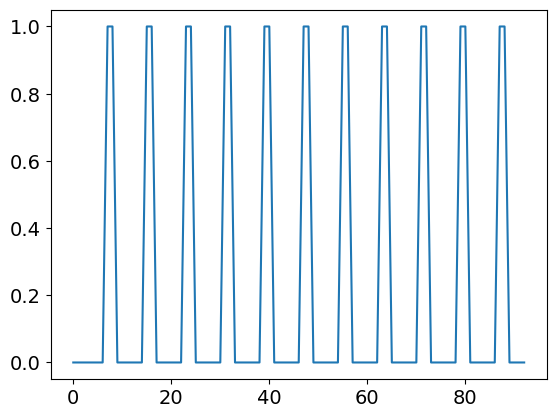

In [19]:
plt.figure()
plt.plot(np.asarray(solsv)[:, bn.output_node_inds[2]])
plt.show()

In [20]:
# %%timeit
cc_o = [0 for i in bn.nodes_index]

sig_vals = [1,0,0,0]
# sig_vals = [0,0,0]

cc_i, char_i = bn.net_state_compute(cc_o,
                              A_bool_f,
                              n_max_steps=len(bn.main_nodes)*2,
                              constraint_inds=bn.input_node_inds,
                              constraint_vals=sig_vals,
                              verbose=verbose,
                              )

In [21]:
cc_i

array([0.   , 0.75 , 0.5  , 1.   , 0.5  , 0.5  , 0.5  , 1.   , 0.5  ,
       0.   , 0.   , 0.5  , 0.   , 0.   , 0.   , 0.625, 0.5  , 0.   ,
       0.   , 0.75 , 0.   , 0.75 , 0.5  , 0.5  , 0.   , 0.5  , 0.25 ,
       0.   , 0.5  , 0.75 , 0.5  , 0.   , 0.   , 0.   , 0.   , 0.5  ,
       0.75 , 0.25 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       1.   , 0.   , 0.   , 0.5  , 0.75 , 0.5  , 0.75 , 0.   ])

In [22]:
char_i

<EquilibriumType.limit_cycle: 2>

In [23]:
node_num_max=5
2**node_num_max

32

In [24]:
len(bn.main_nodes)

46

In [45]:
boolGG, boolpos = bn.bool_state_space(
                                         A_bool_f,
                                         constraint_inds=None,
                                         constraint_vals=None,
                                         signal_constr_vals = [0,0,0, 0],
                                         search_main_nodes_only=True,
                                         n_max_steps=2*len(bn.main_nodes),
                                         node_num_max=node_num_max,
                                         verbose=True)



In [46]:
graph_cycles = sorted(nx.simple_cycles(boolGG))
N_cycles = len(graph_cycles)
out_degree_sequence = [deg_i for nde_i, deg_i in boolGG.out_degree(list(boolGG.nodes))]  # aligns with node order
in_degree_sequence = [deg_i for nde_i, deg_i in boolGG.in_degree(list(boolGG.nodes))]  # aligns with node order

self_loops = list(nx.selfloop_edges(boolGG))
nde_sinks = (np.asarray(out_degree_sequence) == 0).nonzero()[0]
nde_div = np.asarray(out_degree_sequence) - np.asarray(in_degree_sequence)

N_cycles

2

In [47]:
for cyc in graph_cycles:
    print(len(cyc))

1
1


In [48]:
len(self_loops)

2

In [49]:
nde_source = (np.asarray(in_degree_sequence) == 0).nonzero()[0]

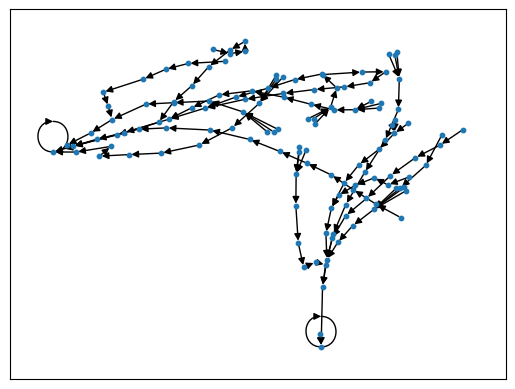

In [50]:
nx.draw_networkx(boolGG, pos=nx.spring_layout(boolGG), with_labels=False, node_size=10)

In [51]:
sol_M, sol_char = bn.solve_system_equms(A_bool_f,
                           constraint_inds = None,
                           constraint_vals = None,
                           signal_constr_vals=[0,0,0,0],
                           search_main_nodes_only=True,
                           n_max_steps=2*len(bn.main_nodes),
                           node_num_max=node_num_max,
                           verbose=False
                           )
sol_M.shape[1]

2

In [52]:
sol_M.shape

(53, 2)

In [53]:
sol_M

array([[0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.]])

In [54]:
sol_char

array([<EquilibriumType.attractor: 0>, <EquilibriumType.attractor: 0>],
      dtype=object)

In [55]:
bsm = BoolStateMachine(bn)

In [56]:
node_num_max=12
output_nodes_only = True
n_max_steps = len(bn.main_nodes)*2
main_nodes_only = True

(solsM_all, 
 charM_all, 
 sols_list, 
 states_dict, 
 sig_test_set) = bsm.steady_state_solutions_search(verbose=False,
                                      search_main_nodes_only=main_nodes_only,
                                      n_max_steps=n_max_steps,
                                      order_by_distance=False,
                                      node_num_max=node_num_max,
                                      output_nodes_only=output_nodes_only
                                      )

In [57]:
(np.asarray(bn.nodes_list)[bn.noninput_node_inds])[np.argsort(bn.hier_node_level[bn.noninput_node_inds])[0:12]]

array(['TGFBR', 'SMAD', 'TAK1', 'TAOK', 'ATM', 'FGFR3', 'GADD45', 'EGFR',
       'GRB2', 'PLCG', 'PKC', 'MTK1'], dtype='<U14')

In [58]:
states_dict

OrderedDict([((0.0, 0.0, 0.0, 0.0),
              {'States': [0, 1],
               'Stability': [<EquilibriumType.attractor: 0>,
                <EquilibriumType.saddle: 3>]}),
             ((0.0, 0.0, 0.0, 1.0),
              {'States': [1, 4],
               'Stability': [<EquilibriumType.saddle: 3>,
                <EquilibriumType.limit_cycle: 2>]}),
             ((0.0, 0.0, 1.0, 0.0),
              {'States': [3, 1],
               'Stability': [<EquilibriumType.limit_cycle: 2>,
                <EquilibriumType.saddle: 3>]}),
             ((0.0, 0.0, 1.0, 1.0),
              {'States': [1, 4],
               'Stability': [<EquilibriumType.saddle: 3>,
                <EquilibriumType.limit_cycle: 2>]}),
             ((1.0, 0.0, 0.0, 0.0),
              {'States': [14, 13, 6, 9, 12],
               'Stability': [<EquilibriumType.limit_cycle: 2>,
                <EquilibriumType.limit_cycle: 2>,
                <EquilibriumType.limit_cycle: 2>,
                <EquilibriumType.limit

In [59]:
solsM_all[bn.output_node_inds, 3]

array([0.        , 0.11111111, 0.88888889])

In [60]:
solsM_all.shape

(53, 15)

In [61]:
len(charM_all)

15

In [62]:
charM_all

array([<EquilibriumType.attractor: 0>, <EquilibriumType.saddle: 3>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>], dtype=object)

In [63]:
save_sols_data = os.path.join(save_path_bool, f'BoolSolM_{libg.name}.csv')
np.savetxt(save_sols_data, solsM_all[bn.noninput_node_inds, :], delimiter=',', header='')

In [64]:
bn.output_node_inds

[4, 21, 37]

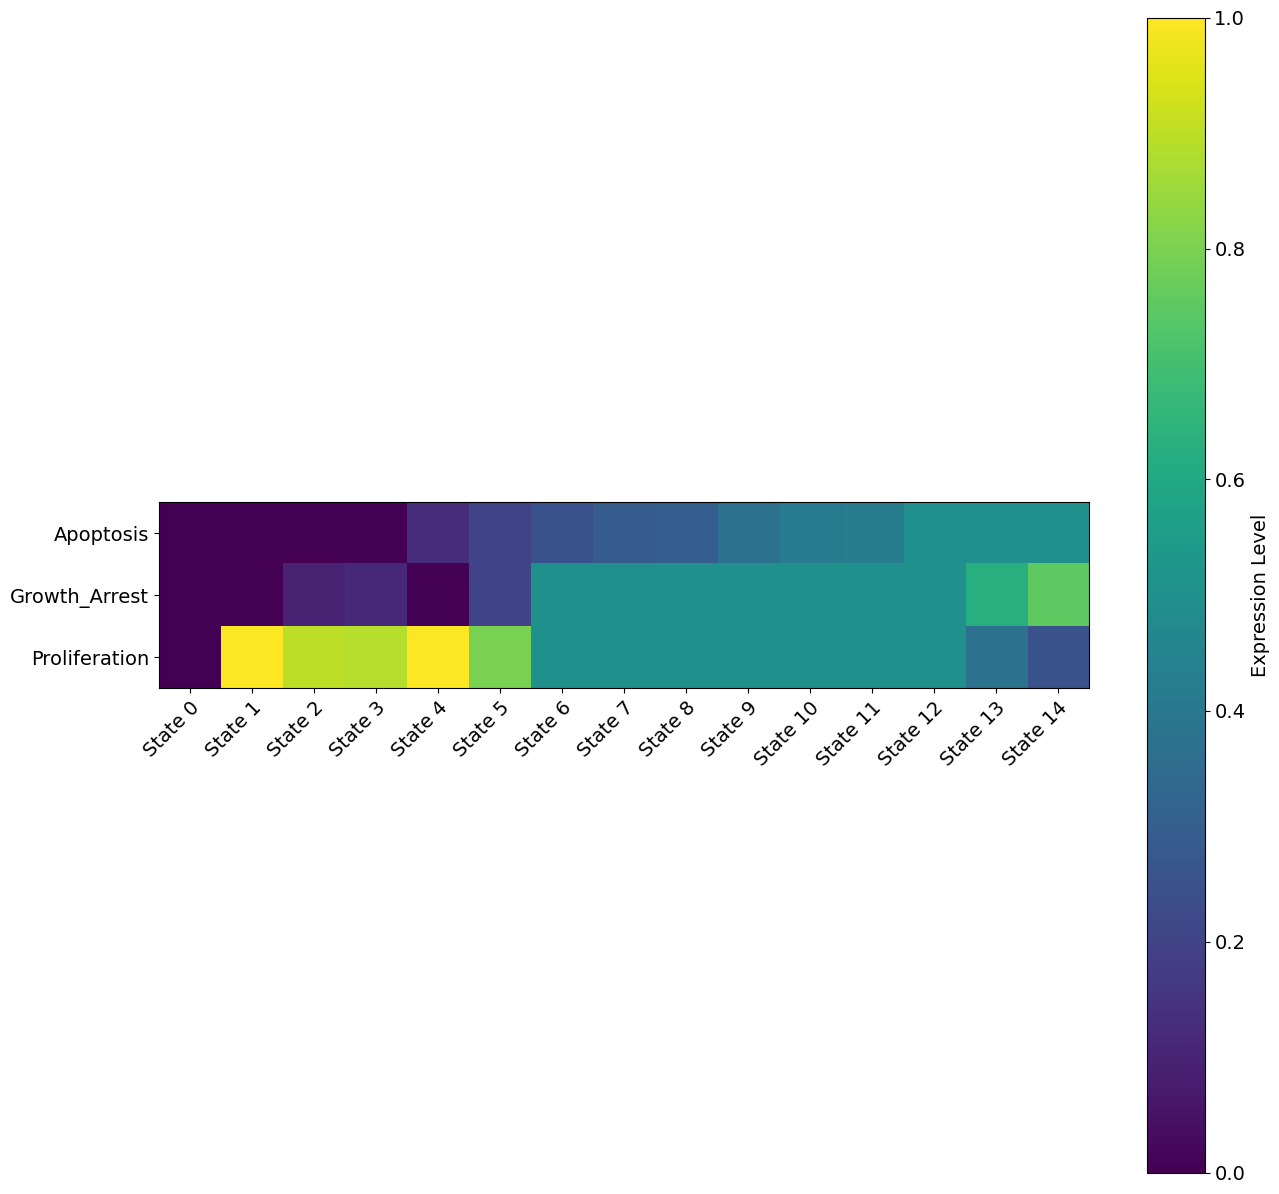

In [65]:
if len(bn.output_node_inds):
    bool_sols_c = f'bool_out_solM_{libg.name}.png'
    save_bool_sols = os.path.join(save_path_bool, bool_sols_c) 

    bn.plot_sols_array(solsM_all,
                            gene_inds = bn.output_node_inds,
                            figsave=save_bool_sols,
                            cmap = 'viridis',
                            save_format = 'png',
                            figsize = (15, 15))

In [66]:
np.setdiff1d(bn.main_nodes, bn.output_node_inds)

array([ 0,  1,  2,  3,  5,  6,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19, 20,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52])

(<Figure size 2000x2000 with 2 Axes>, <Axes: >)

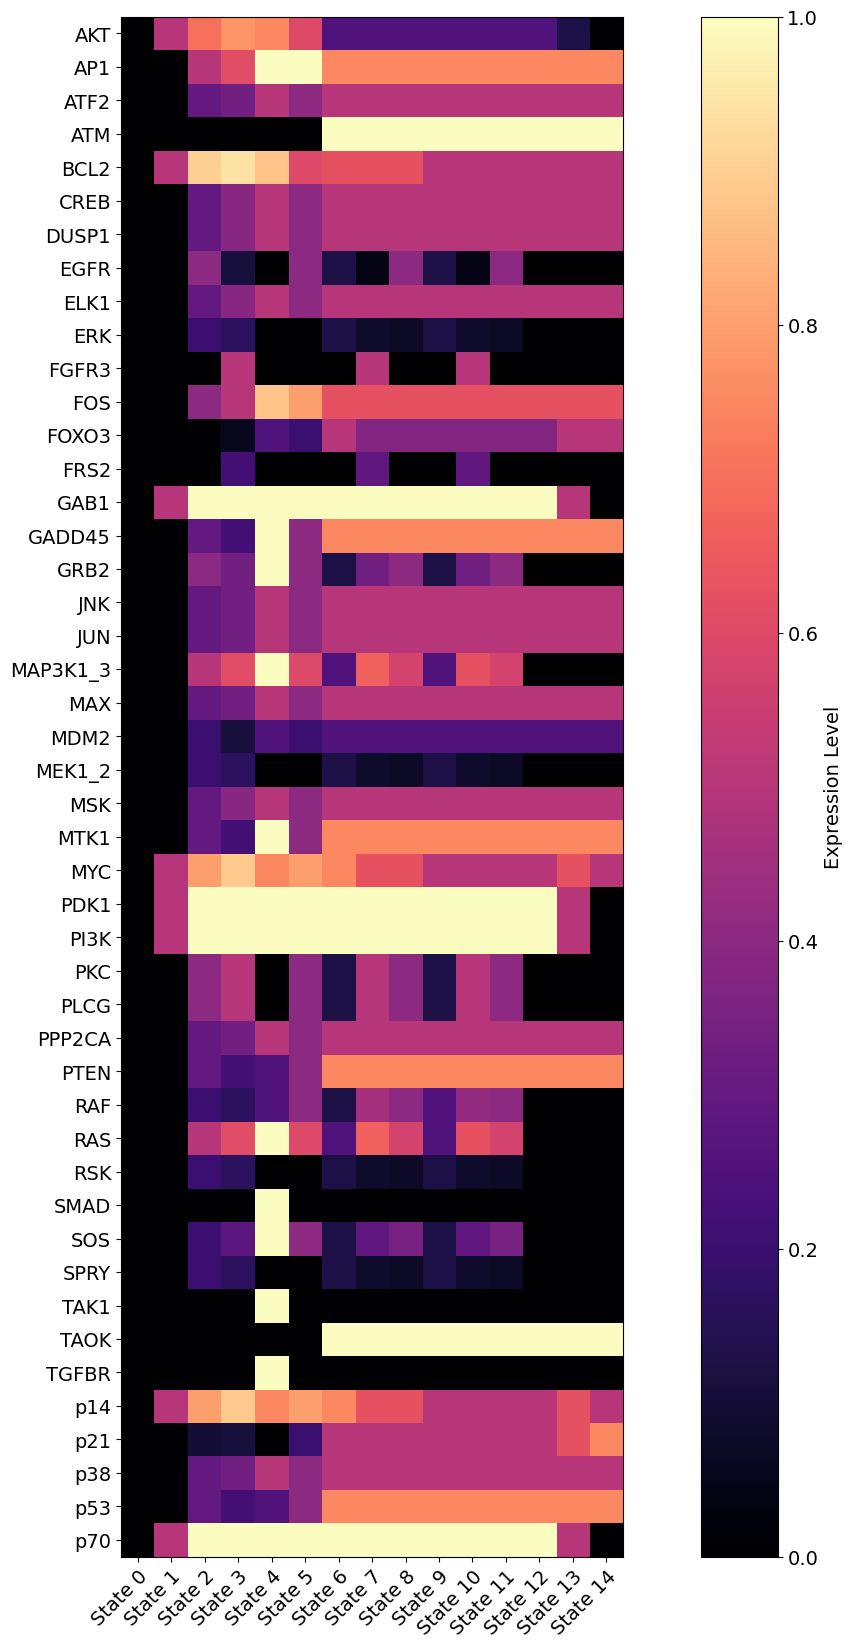

In [67]:
bool_sols_c = f'bool_solM_{libg.name}.png'
save_bool_sols = os.path.join(save_path_bool, bool_sols_c) 

bn.plot_sols_array(solsM_all,
                        gene_inds = np.setdiff1d(bn.main_nodes, bn.output_node_inds),
                        figsave=save_bool_sols,
                        cmap = None,
                        save_format = 'png',
                        figsize = (20, 20))


In [68]:
gNFSM_edges_set, eNFSM_edges_set, GG = bsm.create_transition_network(
                                  states_dict,
                                  sig_test_set,
                                  solsM_all,
                                  verbose = False,
                                  remove_inaccessible_states=False,
                                  save_graph_file = None,
                                  n_max_steps=n_max_steps,
                                  output_nodes_only=output_nodes_only
                                  )

In [69]:
gNFSM_edges_set

{(0, 0, 0),
 (0, 1, 1),
 (0, 1, 3),
 (0, 1, 9),
 (0, 1, 11),
 (0, 2, 8),
 (0, 2, 10),
 (0, 3, 2),
 (0, 9, 5),
 (0, 9, 7),
 (0, 9, 13),
 (0, 9, 15),
 (0, 10, 6),
 (0, 11, 12),
 (0, 11, 14),
 (0, 14, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 3),
 (1, 1, 9),
 (1, 1, 11),
 (1, 2, 8),
 (1, 2, 10),
 (1, 3, 2),
 (1, 9, 4),
 (1, 9, 5),
 (1, 9, 7),
 (1, 9, 13),
 (1, 9, 15),
 (1, 10, 6),
 (1, 11, 12),
 (1, 11, 14),
 (1, 12, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 3),
 (2, 1, 9),
 (2, 1, 11),
 (2, 2, 8),
 (2, 2, 10),
 (2, 3, 2),
 (2, 9, 5),
 (2, 9, 7),
 (2, 9, 13),
 (2, 9, 15),
 (2, 10, 6),
 (2, 11, 12),
 (2, 11, 14),
 (2, 12, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 3),
 (3, 1, 9),
 (3, 1, 11),
 (3, 2, 8),
 (3, 2, 10),
 (3, 3, 2),
 (3, 9, 5),
 (3, 9, 7),
 (3, 9, 13),
 (3, 9, 15),
 (3, 10, 6),
 (3, 11, 12),
 (3, 11, 14),
 (3, 12, 4),
 (4, 1, 1),
 (4, 1, 3),
 (4, 1, 9),
 (4, 1, 11),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 3),
 (5, 1, 9),
 (5, 1, 11),
 (5, 3, 2),
 (5, 5, 8),
 (5, 5, 10),
 (5, 6, 5),
 (5, 6, 7),
 (5, 6, 1

In [70]:
# Next, define phenomenological biological states based on the individual outputs:
cancer_state_A = [0.0, 0.0, 1.0]
cancer_state_B = [0.0, 0.5, 1.0]
cancer_state_C = [0.1, 0.0, 1.0]
senescence_phenotype = [0.0, 1.0, 0.0]
normal_cell_A = [0.5, 0.5, 0.5]
normal_cell_B = [0.5, 0.0, 0.5]
indeterminite_cell_state = [0.0, 0.0, 0.0]

test_state = cancer_state_C

test_inds = bn.output_node_inds

# Now, let's find the best match in the state matrix for each of these:
match_state, match_error = bsm._find_state_match(bsm._solsM_all[test_inds, :], test_state)

cancer_metric = []
for state_i in bsm._solsM_all[test_inds, :].T:
    cancer_metric.append(np.linalg.norm(state_i - cancer_state_A))


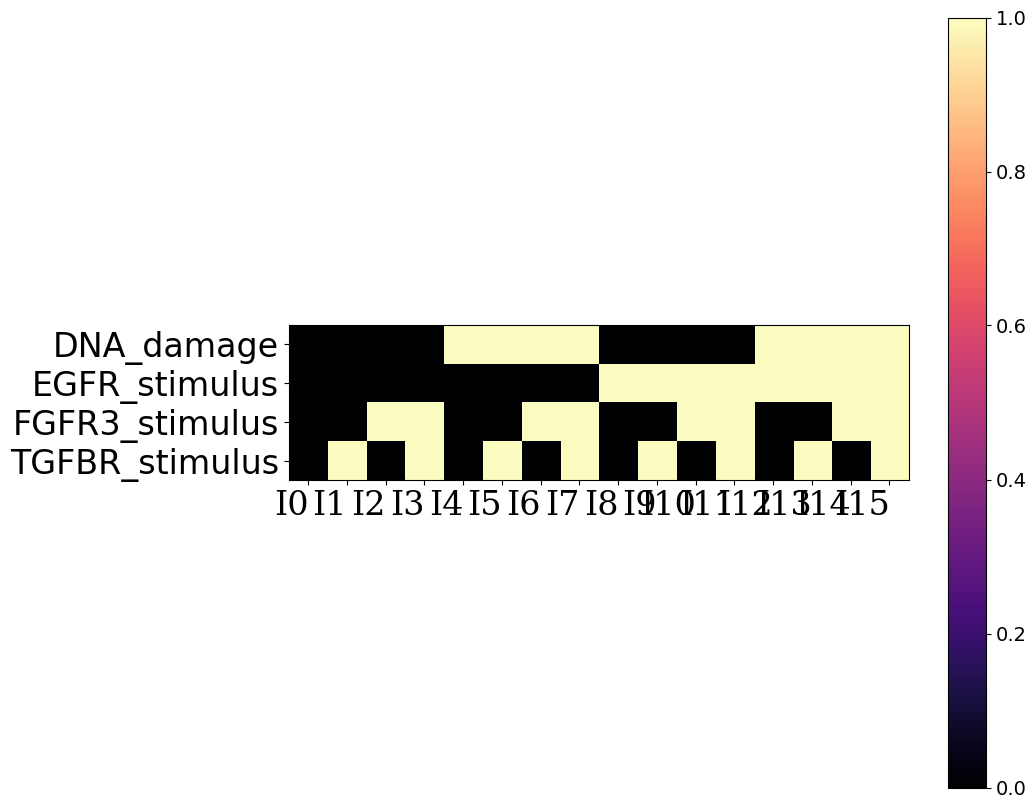

In [71]:
y_input_labels = [bn.nodes_list[ni] for ni in bn.input_node_inds]
x_input_labels = [f'I{ni}' for ni, _ in enumerate(sig_test_set)]

save_inputs_image = os.path.join(save_path_bool, f'Bool_Inputs_{libg.name}_smach.png')
fig, ax = bn.plot_pixel_matrix(sig_test_set.T,
                          x_input_labels,
                           y_input_labels,
                         figsave=save_inputs_image,
                         cmap=None,
                               figsize=(10,10),
                               fontsize=24
                         )

In [75]:
# Plotting and saving the gNFSM and eNFSM:
save_microarray_image = os.path.join(save_path_bool, f'BoolMicroarray_{libg.name}_found.png')
fig, ax = bn.plot_sols_array(bsm._solsM_all, 
                     gene_inds = bn.noninput_node_inds,
                          figsave = save_microarray_image,
                          cmap =None,
                          save_format='png'
                          )
plt.close(fig)

# Save the input states to a csv file:
save_inputss_data = os.path.join(save_path_bool, f'BoolInputStates_{libg.name}.csv')
# headr = [f'{ni},' for ni in np.asarray(smach.Receptor tyrosine kinases_pnet.nodes_list)[smach._pnet.input_node_inds]]
np.savetxt(save_inputss_data, sig_test_set, 
           delimiter=',', header='')

# Save the solution states to a csv file:
save_sols_data = os.path.join(save_path_bool, f'BoolSolsStates_{libg.name}.csv')
# headr = [f'State {i},' for i in range(smach._solsM_all.shape[1])]
np.savetxt(save_sols_data, bsm._solsM_all[bsm._bnet.noninput_node_inds, :], 
           delimiter=',', header='')

if len(bsm._charM_ext):
    charM_all_2 = np.hstack((charM_all, bsm._charM_ext))
else:
    charM_all_2 = charM_all


nodes_list = list(GG.nodes())
edges_list = list(GG.edges)


if mono_edge is True:
    mono_lab = 'monoedge'
else:
    mono_lab = 'multiedge'


save_perturbation_net_image = os.path.join(save_path_bool, f'Bool_Pert_Net_{libg.name}_' + mono_lab + fimg)
G_pert = bsm.plot_state_perturbation_network(eNFSM_edges_set,
                                               charM_all_2,
                                               nodes_listo=nodes_list,
                                               save_file=save_perturbation_net_image,
                                              graph_layout='dot',
                                              mono_edge=mono_edge,
                                              constraint= True,
                                              concentrate = False,
                                             node_colors=cancer_metric,
                                              cmap_str='RdBu',
                                                transp_str='60',
                                               rank='same'
                                              )


save_transition_net_image = os.path.join(save_path_bool, f'Bool_Trans_Net_{libg.name}_' + mono_lab + fimg)
G_gv = bsm.plot_state_transition_network(nodes_list,
                                                      edges_list,
                                                      charM_all_2,
                                                      save_file=save_transition_net_image,
                                                      graph_layout='dot',
                                                      mono_edge=True,
                                                      constraint= True,
                                                       concentrate = False,
                                                      node_colors=cancer_metric,
                                                      rank='same',
                                                      cmap_str='RdBu',
                                                      transp_str='60'
                                         
                                                      )

y_input_labels = [bn.nodes_list[ni] for ni in bn.input_node_inds]
x_input_labels = [f'I{ni}' for ni, _ in enumerate(sig_test_set)]

save_inputs_image = os.path.join(save_path_bool, f'Bool_Inputs_{libg.name}_smach.png')
fig, ax = bn.plot_pixel_matrix(sig_test_set.T,
                          x_input_labels,
                           y_input_labels,
                         figsave=save_inputs_image,
                         cmap=None,
                               figsize=(20,10),
                               fontsize=18
                         )

plt.close(fig)

In [113]:
new_edges = []
new_nodes = set()
for nde_i, nde_j, edge_label in list(GG.edges):
    # if nde_i == '1' or nde_i == '2' or nde_i == '3':
    if nde_i == '2':
        new_nodes.add(nde_i)
        new_nodes.add(nde_j)
        new_edges.append((nde_i, nde_j, edge_label))

In [83]:
new_nodes

{'1', '10', '11', '12', '2', '3', '9'}

In [95]:
test_inds

[4, 21, 37]

In [96]:
bsm._solsM_all[test_inds, :]

array([[0.        , 0.        , 0.        , 0.        , 0.125     ,
        0.2       , 0.25      , 0.29166667, 0.3       , 0.375     ,
        0.41666667, 0.425     , 0.5       , 0.5       , 0.5       ],
       [0.        , 0.        , 0.1       , 0.11111111, 0.        ,
        0.2       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.625     , 0.75      ],
       [0.        , 1.        , 0.9       , 0.88888889, 1.        ,
        0.8       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.375     , 0.25      ]])

In [108]:

nodes_list_2 = [int(ni) for ni in new_nodes]
img_pos = 'bc'  # position of the glyph in the node
subcluster_font = 'DejaVu Sans Bold'
node_shape = 'ellipse'
clr_map = 'RdBu'
nde_font_color = 'Black'
hex_transparency = '60'
node_colors = cancer_metric
fontsize = 24.0

# Try to make a nested graph:
G = pgv.AGraph(strict=False,
               fontname=subcluster_font,
               splines=True,
               directed=True,
               concentrate=False,
               constraint=False,
               rank='same',
               dpi=300)

cmap = colormaps[clr_map]


norm = colors.Normalize(vmin=np.min(node_colors),
                            vmax=np.max(node_colors))

# Add all the nodes:
for nde_i in nodes_list_2:
    nde_lab = nde_i
    nde_index = nodes_list_2.index(nde_i)

    nde_color = colors.rgb2hex(cmap(norm(node_colors[nde_i])))

    nde_color += hex_transparency  # add some transparancy to the node

    char_i = charM_all[nde_i].name # Get the stability characterization for this state

    G.add_node(nde_i,
                   label=f'State {nde_lab}',
                   # fontsize=24.0,
                   # font=subcluster_font,
                   labelloc='t',
                   image=bsm._node_image_dict[char_i],
                   imagepos=img_pos,
                   shape=node_shape,
                   fontcolor=nde_font_color,
                   style='filled',
                   fillcolor=nde_color)


# Add all the edges:
for nde_i, nde_j, trans_ij in new_edges:
    G.add_edge(nde_i, nde_j, label=trans_ij, fontsize=fontsize)
    
save_transition_net_image = os.path.join(save_path_bool, f'Bool_Trans_Net_HealCancer_{libg.name}_' + mono_lab + '.svg')

G.layout(prog=graph_layout)
G.draw(save_transition_net_image)


In [114]:

nodes_list_3 = [int(ni) for ni in nodes_list]
img_pos = 'bc'  # position of the glyph in the node
subcluster_font = 'DejaVu Sans Bold'
node_shape = 'ellipse'
clr_map = 'RdBu'
nde_font_color = 'Black'
hex_transparency = '60'
node_colors = cancer_metric
fontsize = 24.0

# Try to make a nested graph:
G = pgv.AGraph(strict=False,
               fontname=subcluster_font,
               splines=True,
               directed=True,
               concentrate=False,
               constraint=False,
               rank='same',
               dpi=300)

cmap = colormaps[clr_map]


norm = colors.Normalize(vmin=np.min(node_colors),
                            vmax=np.max(node_colors))

# Add all the nodes:
for nde_i in nodes_list_3:
    nde_lab = nde_i
    nde_index = nodes_list_3.index(nde_i)

    nde_color = colors.rgb2hex(cmap(norm(node_colors[nde_i])))

    nde_color += hex_transparency  # add some transparancy to the node

    char_i = charM_all[nde_i].name # Get the stability characterization for this state

    G.add_node(nde_i,
                   label=f'State {nde_lab}',
                   # fontsize=24.0,
                   # font=subcluster_font,
                   labelloc='t',
                   image=bsm._node_image_dict[char_i],
                   imagepos=img_pos,
                   shape=node_shape,
                   fontcolor=nde_font_color,
                   style='filled',
                   fillcolor=nde_color)


# Add all the edges:
for nde_i, nde_j, trans_ij in edges_list:
    G.add_edge(nde_i, nde_j, label=trans_ij, fontsize=fontsize)
    
save_transition_net_image = os.path.join(save_path_bool, f'Bool_FullTrans_Net_HealCancer_{libg.name}_' + mono_lab + '.png')

G.layout(prog=graph_layout)
G.draw(save_transition_net_image)

In [85]:
np.asarray(bn.nodes_list)[bn.input_node_inds]

array(['DNA_damage', 'EGFR_stimulus', 'FGFR3_stimulus', 'TGFBR_stimulus'],
      dtype='<U14')

In [86]:
bsm._solsM_all.shape, solsM_all.shape

((53, 15), (53, 15))

In [87]:
charM_all

array([<EquilibriumType.attractor: 0>, <EquilibriumType.saddle: 3>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>, <EquilibriumType.limit_cycle: 2>,
       <EquilibriumType.limit_cycle: 2>], dtype=object)

In [143]:
match_state, match_error

(4, 0.024999999999999994)

In [144]:
test_state

[0.1, 0.0, 1.0]

In [134]:
errM = []
for soli in bsm._solsM_all.T:
    sdiff = soli[test_inds] - test_state
    errM.append(np.sqrt(np.sum(sdiff ** 2)))
errM = np.asarray(errM)

In [135]:
np.argsort(errM)

array([ 0,  6,  7,  8,  9, 10, 11,  5, 12, 13,  3,  2, 14,  1,  4])

In [140]:
bsm._solsM_all[test_inds, 4]

array([0.125, 0.   , 1.   ])

In [48]:
cc_o = bsm._solsM_all[:, 50]
sig_pert = sig_test_set[14]
cc_o[bn.input_node_inds] = sig_pert
sig_base = sig_test_set[1]

In [50]:
solsv_held, cc_held, sol_char_held, motif_held = bn.net_sequence_compute(cc_o,
                                                      A_bool_f,
                                                      n_max_steps=n_max_steps,
                                                      constraint_inds=bn.input_node_inds,
                                                      constraint_vals=sig_pert.tolist(),
                                                      verbose=verbose,
                                                      )

solsv_new, cc_new, sol_char_new, motif_new = bn.net_sequence_compute(cc_held,
                                                      A_bool_f,
                                                      n_max_steps=n_max_steps,
                                                      constraint_inds=bn.input_node_inds,
                                                      constraint_vals=sig_base.tolist(),
                                                      verbose=verbose,
                                                      )

In [60]:
solsv = solsv_new
solvr = np.asarray(solsv)[:, bn.noninput_node_inds] # get the reduced array
si = solvr[-1, :] # try selecting the last state to check for repetition...
matched_inds = [i for i, x in enumerate(solvr.tolist()) if x == si.tolist()] # look for repetition
if len(matched_inds) > 1: # if there's more than one incidence of the state
    motif_period = matched_inds[-1] - matched_inds[-2]


In [63]:
len(solsv)

93

In [67]:
matched_inds[-2]

84

In [68]:
motif_B = solvr[matched_inds[-2]:matched_inds[-1]]
motif_A = solvr[matched_inds[-4]:matched_inds[-3]]

In [70]:
len(motif_A)

8

In [73]:
for si in motif_A:
    print(np.linalg.norm(si))

4.58257569495584
4.242640687119285
4.123105625617661
4.47213595499958
5.291502622129181
5.477225575051661
5.744562646538029
5.385164807134504


In [72]:
for si in motif_B:
    print(np.linalg.norm(si))

4.58257569495584
4.242640687119285
4.123105625617661
4.47213595499958
5.291502622129181
5.477225575051661
5.744562646538029
5.385164807134504


In [61]:
motif_period

8

In [51]:
cc_new

array([0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1.])

In [52]:
cc_o

array([0.75 , 0.75 , 0.5  , 0.   , 0.   , 0.875, 0.5  , 1.   , 0.5  ,
       0.   , 1.   , 0.5  , 0.125, 0.   , 1.   , 0.625, 0.   , 0.   ,
       1.   , 1.   , 1.   , 0.   , 0.5  , 0.5  , 0.875, 0.5  , 0.25 ,
       0.125, 0.5  , 1.   , 0.75 , 1.   , 1.   , 0.   , 0.   , 0.5  ,
       0.25 , 1.   , 0.125, 0.875, 0.125, 1.   , 0.875, 0.125, 1.   ,
       0.   , 1.   , 0.   , 0.75 , 0.   , 0.5  , 0.25 , 1.   ])

In [55]:
cc_i[bn.noninput_node_inds]

array([0.   , 0.75 , 0.5  , 1.   , 0.5  , 0.5  , 0.5  , 0.5  , 0.   ,
       0.5  , 0.   , 0.   , 0.625, 0.5  , 0.   , 0.   , 0.75 , 0.   ,
       0.75 , 0.5  , 0.5  , 0.   , 0.5  , 0.25 , 0.   , 0.5  , 0.75 ,
       0.5  , 0.   , 0.   , 0.   , 0.   , 0.5  , 0.75 , 0.25 , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.5  ,
       0.75 , 0.5  , 0.75 , 0.   ])

In [54]:
new_state, match_error = bsm._find_state_match(bsm._solsM_all[bn.noninput_node_inds, :],
                                                                                cc_new[bn.noninput_node_inds])

In [55]:
new_state

56

In [56]:
match_error

0.0